# Time-dependent word embeddings

In [0]:
import numpy as np
import pandas as pd
from scipy import sparse as sp
import scipy.io as sio

from tqdm import tnrange, tqdm_notebook

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.despine()

%matplotlib inline

## Data

In [0]:
from utils import *

In [0]:
!wget https://www.dropbox.com/s/nifi5nj1oj0fu2i/data.zip
!unzip data.zip

In [0]:
corpus = Corpus()

## Models

In [0]:
#from dynamic_wv import DynamicW2V
from aligned_w2v import AlignedW2V
from projector_splitting_w2v import IntegratedW2V

DynamicW2V fits long

In [0]:
ridge_w2v = DynamicW2V()
projector_w2v = IntegratedW2V()
aligned_w2v = AlignedW2V()

#models = [ridge_w2v, projector_w2v, aligned_w2v]
models = [projector_w2v, aligned_w2v]

for model in models:
    model.fit(corpus)

# Evaluation

## Semantic analysis (t-SNE visualization )

In [0]:
import scipy.io as sio
import numpy as np
import json
from pprint import pprint
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pickle


word = 'apple'

def TSNE_pr(word, model, corpus, times = range(0,27)):
    nn = 50
    nc = 5
    X = []
    list_of_words = []
    isword = []
    for year in times:

        emb = model.embeddings[year]
        embnrm = np.reshape(np.sqrt(np.sum(emb**2,1)),(emb.shape[0],1))
        emb_normalized = np.divide(emb, np.tile(embnrm, (1,emb.shape[1])))           
        v = emb_normalized[corpus.vocab[word],:]
        d =np.dot(emb_normalized,v)
        idx = np.argsort(d)[::-1]
        newwords = [(model.inv_vocab[k], year) for k in list(idx[:nn])]
        list_of_words.extend(newwords)
        for k in range(nn):
            isword.append(k==0)
        X.append(emb[idx[:nn],:])

    X = np.vstack(X)
    model = TSNE(n_components=2, metric = 'euclidean')
    Z = model.fit_transform(X)
    return Z, list_of_words, isword
  
Z, list_of_words, isword = TSNE_pr(word=word, model=projector_w2v, corpus=corpus, times = range(0,27))

In [0]:
sio.savemat('{}_tsne.mat'.format(word),{'emb':Z})
pickle.dump({'words':list_of_words,'isword':isword},open('%s_tsne_wordlist.pkl'%word,'wb'))

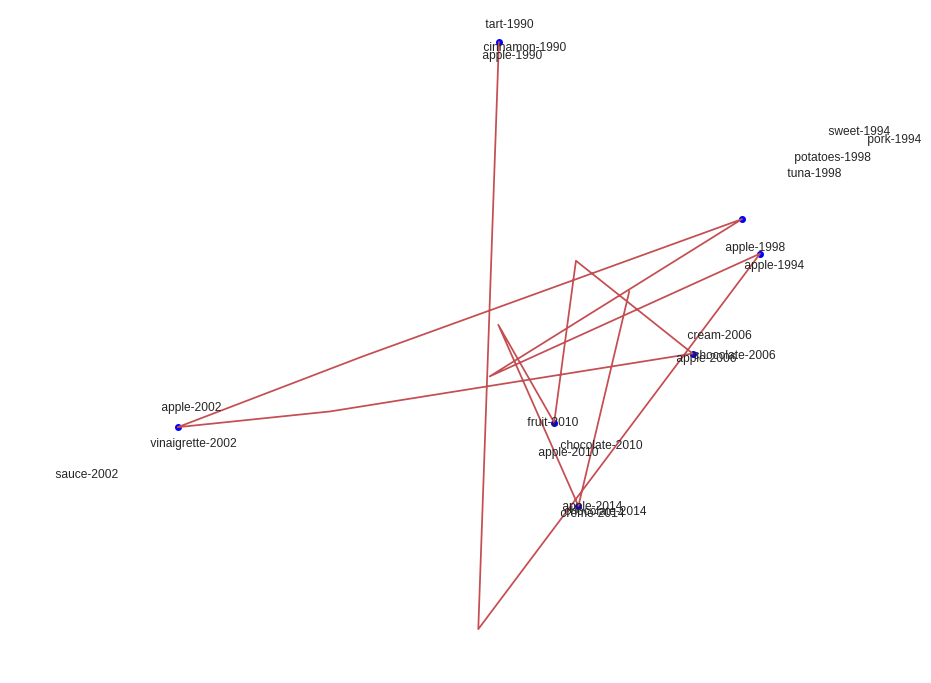

In [82]:
def plot_k_nearest(model, list_of_words, isword, Z,  word, pic_name):
    Z = sio.loadmat('%s_tsne.mat'%word)['emb']
    data = pickle.load(open('%s_tsne_wordlist.pkl'%word,'rb'))
    plt.clf()
    traj = []

    Zp = Z*1.
    Zp[:,0] = Zp[:,0]*2.
    all_dist = np.zeros((Z.shape[0],Z.shape[0]))
    for k in range(Z.shape[0]):
        all_dist[:,k] =np.sum( (Zp - np.tile(Zp[k,:],(Z.shape[0],1)))**2.,axis=1)

    dist_to_centerpoints = all_dist[:,isword]
    dist_to_centerpoints = np.min(dist_to_centerpoints,axis=1)

    dist_to_other = all_dist + np.eye(Z.shape[0])*1000.
    idx_dist_to_other = np.argsort(dist_to_other,axis=1)
    dist_to_other = np.sort(dist_to_other,axis=1)
    plt.figure(figsize=(16,12))
    plt.clf()
    y = 0
    for k in range(len(list_of_words)-1,-1,-1):   
        if isword[k] :
            y += 1
#             if list_of_words[k][1] % 3 != 0 : continue
            marker = 'bo'
            traj.append(Z[k,:])
            if (y%4) == 3 :
                plt.plot(Z[k,0], Z[k,1],marker)
                plt.text(Z[k,0]-2, Z[k,1]+np.random.randn()*2,' %s-%d' % (list_of_words[k][0], list_of_words[k][1] + 1990), fontsize = 12)
            
    times = np.arange(27)

    for t in times[::4]:
        w = (model.k_nearest(word)[t][0][0], t)
        w1 = (model.k_nearest(word)[t][1][0], t)
        if (w in list_of_words):
            k = list_of_words.index(w)
            plt.plot(Z[k,0], Z[k,1])
            plt.text(Z[k,0]-2, Z[k,1]+np.random.randn()*2,' %s-%d' % (list_of_words[k][0], list_of_words[k][1] + 1990), fontsize = 12)
        if (w1 in list_of_words):
            k = list_of_words.index(w1)
            plt.plot(Z[k,0], Z[k,1])
            plt.text(Z[k,0]-2, Z[k,1]+np.random.randn()*2,' %s-%d' % (list_of_words[k][0], list_of_words[k][1] + 1990), fontsize = 12)
    plt.axis('off')
    traj = np.vstack(traj)
    plt.plot(traj[::2,0],traj[::2,1])
    pic_name = word
    plt.savefig('./{}2.png'.format(pic_name))
    plt.show()

plot_k_nearest(projector_w2v, word=word, pic_name=word, list_of_words=list_of_words, Z=Z, isword=isword)

## k-means clusterization 

### prepare word-topic pairs

In [0]:
import numpy as np
from collections import Counter

def read_file(path):
    nyTimesFile = open(path, encoding='utf-8')
    nyTimesFile.seek(0)
    nyTimesV1 = nyTimesFile.readlines()
    return nyTimesV1

In [0]:
def process_data(data, amount):
    # make data more appropriate for processing
    new_array = list()
    for line in data:
        if line != "\n":
            new_array.append(line)
    data_list = [word.strip() for word in new_array]
    test = data_list[0:amount]
    dictionary = {}
    
    tag = ""
    for line in test:
        if "http" in line and len(line) < 150:
            tag = line[39:].split("/")[0] 
        else:
            curr_line = line.lower()
            curr_line = curr_line.replace(",","")
            curr_line = curr_line.replace(".","")
            curr_line = curr_line.replace("-","")
            curr_line = curr_line.replace("“","")
            counter_obj = Counter(curr_line.split(" "))
            if tag in dictionary:
                dictionary[tag] += counter_obj
            else:
                dictionary[tag] = counter_obj
    
    # make a single Counter
    cnt = Counter()
    for k,v in dictionary.items():
        cnt += v
        
    words_indexes = lambda dictionary: {i: list(dictionary.keys()).index(i) for i in dictionary}
    indexes = words_indexes(cnt) # words
    topic_indexes = {}
    
    topic_length = len(dictionary)
    vocab_length = len(indexes)
    
    corpus_matrix = np.zeros((vocab_length, topic_length), dtype='float32')
    i = 0
    for k,v in dictionary.items():
        topic_indexes[i] = k
        for key, value in v.items():
            corpus_matrix[indexes[key], i] = value
        i += 1
    
    for j in range(i):
        row_sum = np.sum(corpus_matrix[j,:])
        corpus_matrix[j,:] = corpus_matrix[j,:] / row_sum
        
    inv_map = {v: k for k, v in indexes.items()}
    word_topic_dict = {}
    for i in range(vocab_length):
        indices = np.where(corpus_matrix[i,:] >= 0.35)
        word = inv_map[i]
        if indices[0].size != 0:
            topic = topic_indexes[indices[0][0]]
            word_topic_dict[word] = topic
    
    return word_topic_dict

In [0]:
def save_results_txt(result,filename="last_res.txt"):
    with open(filename, "w") as f:
        for k,v in result.items():
            line = k + " " + v + "\n"
            f.write(line)

In [0]:
path = 'nytimes_news_articles.txt'
data = read_file(path)
word_topic_dict = process_data(data, 100000)

y - labels for each category

X contains embeddings of chosen words for each model

In [0]:
idx = []
y = []

for key, val in word_topic_dict:
    if key in corpus.vocab:
        idx.append(corpus.vocab[s[0]])
        y.append(val)

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [0]:
X = []

for model in models:
    X.append(model.embeddings[-1][idx])

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score

$F_{\beta}$ measure for each pair of words. Positive - words are from the same topic, negative otherwise. True positive - words are from the same topic and are from the same k-means cluster etc.

In [0]:
def f_measure(y_true, y_pred, beta):
    true = (y_true == y_true.reshape(-1, 1))
    pred = (y_pred == y_pred.reshape(-1, 1))
    TP = np.sum(true*pred)
    FP = np.sum(np.logical_not(true)*pred)
    FN = np.sum(np.logical_not(pred)*true)
    precision = TP/(TP + FP)
    recall = TP / (TP + FN)
    return (beta**2 + 1)*precision*recall/(beta**2*precision + recall)

experiment for different number of clusters

In [0]:
n_clusters = [5, 10, 15, 20]
NMI_score = {n: [] for n in n_clusters}
fbeta_score = {n: [] for n in n_clusters}

for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    for x in X:
        kmeans.fit(x)
        y_pred = kmeans.labels_
        NMI_score[n] = NMI_score[n].append(normalized_mutual_info_score(y, y_pred))
        fbeta_score[n] = fbeta_score[n].append(f_measure(y, y_pred, 5))  

## Symmetry loss of projector-splitting method 

Test method for small random symmetric matrices with different SNR

$\frac{\|Y - Y.T\|}{\|Y\|}$

In [0]:
def step(U, S, V, dA):
    K = U.dot(S) + dA.dot(V)
    U_, S_hat = np.linalg.qr(K)
    S_tilde = S_hat - U_.T.dot(dA).dot(V)
    L = V.dot(S_tilde.T) + dA.T.dot(U_)
    V_, ST = np.linalg.qr(L)
    S_ = ST.T
    return U_, S_, V_

In [0]:
sym_loss = []
SNR = [0.01, 0.05, 0.1, 0.5]

A = np.random.randn(500, 500)
A += A.T
r = 50
U, S, Vh = np.linalg.svd(A)
U = U[:, :r]
S = np.diag(S[:r])
V = Vh.T[:, :r]

M = U.dot(S).dot(V.T)

for snr in SNR:
    loss = []
    for i in range(50):
        noise = snr*np.random.randn(500, 500)
        noise += noise.T
        U, S, V = step(U, S, V, noise)
        M = U.dot(S).dot(V.T)
        loss.append(np.linalg.norm(M - M.T)/np.linalg.norm(M))
    sym_loss.append(loss)

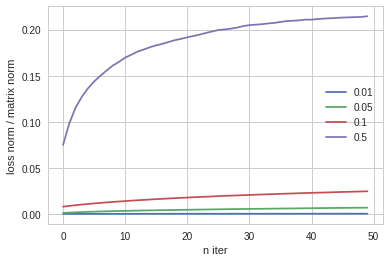

In [0]:
for i, loss in enumerate(sym_loss):
    plt.plot(loss, label = str(SNR[i]))
    plt.xlabel('n iter')
    plt.ylabel('loss norm / matrix norm')
    plt.legend(loc = 'best')

rotated U, V, $\frac{\|U - V\|}{\|U\|}$

In [0]:
from scipy.spatial import procrustes
sym_loss = []
SNR = [0.01, 0.05, 0.1, 0.5]

A = np.random.randn(500, 500)
A += A.T
r = 50
U, S, Vh = np.linalg.svd(A)
U = U[:, :r]
S = np.diag(S[:r])
V = Vh.T[:, :r]

M = U.dot(S).dot(V.T)

for snr in SNR:
    loss = []
    for i in range(50):
        noise = snr*np.random.randn(500, 500)
        noise += noise.T
        U, S, V = step(U, S, V, noise)
        u, s, v = np.linalg.svd(S)
        v = v.T
        U_, V_, l = procrustes(U.dot(u*np.sqrt(s)), V.dot(v*np.sqrt(s)))
        loss.append(l)
    sym_loss.append(loss)

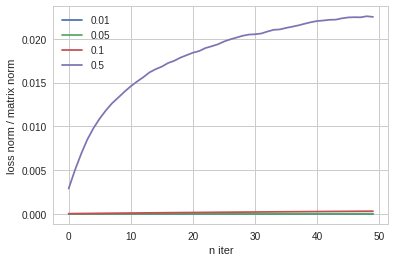

In [0]:
for i, loss in enumerate(sym_loss):
    plt.plot(loss, label = str(SNR[i]))
    plt.xlabel('n iter')
    plt.ylabel('loss norm / matrix norm')
    plt.legend(loc = 'best')

real data

rotated U, V, $\frac{\|U - V\|}{\|U\|}$

In [0]:
w2v = IntegratedW2V()
w2v.fit(corpus)

Text(0,0.5,'symmetry loss')

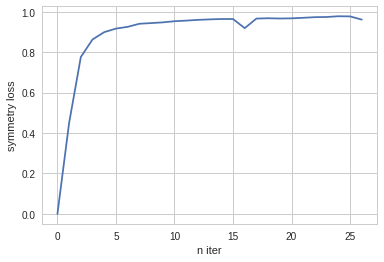

In [67]:
plt.plot(w2v.symmetry_loss)
plt.xlabel('n iter')
plt.ylabel('symmetry loss')

In [0]:
w2v.k_nearest('trump')

[[('bondholders', 0.9225145976587661),
  ('casinos', 0.9041482331691848),
  ('bankers', 0.8762187916008849),
  ('casino', 0.8535754395216528),
  ('lenders', 0.8284061593735002)],
 [('plaza', 0.7380343481434888),
  ('properties', 0.7354609264887819),
  ('bankers', 0.7351865649139775),
  ('taj', 0.7244524233207985),
  ('developer', 0.7103526766856495)],
 [('spade', 0.5847293959144038),
  ('ruff', 0.5809267865822539),
  ('ace', 0.5753869670225484),
  ('landlord', 0.5575989078812053),
  ('dummy', 0.5562256799307366)],
 [('condominiums', 0.4317796023129664),
  ('apartments', 0.39338460600804853),
  ('vegas', 0.3924696389207172),
  ('negotiated', 0.38500933902982365),
  ('sears', 0.38150227147394544)],
 [('condominiums', 0.48120423144942664),
  ('55th', 0.43654039020538093),
  ('foreclosure', 0.43322851694981346),
  ('negotiated', 0.4177233135816258),
  ('59th', 0.4075831941249997)],
 [('casinos', 0.5713271766721575),
  ('mortgage', 0.5223184201943939),
  ('plaza', 0.49480758109581735),
  ('